<a href="https://colab.research.google.com/github/WeiHao97/Security_SysML/blob/main/quantAwareTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
from collections import namedtuple

In [3]:
import os

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# MNIST Model

In [5]:
class Net(nn.Module):
    def __init__(self, mnist=True):
      
        super(Net, self).__init__()
        if mnist:
            num_channels = 1
        else:
            num_channels = 3
          
        self.conv1 = nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        if mnist:
            self.fc1 = nn.Linear(4*4*50, 500)
            self.flatten_shape = 4*4*50
        else:
            self.fc1 = nn.Linear(1250, 500)
            self.flatten_shape = 1250

        self.fc2 = nn.Linear(500, 10)
        
      
    def forward(self, x, vis=False, axs=None):
        X = 0
        Y = 0

        if vis:
            axs[X,Y].set_xlabel('Entry into network, input distribution visualised below: ')
            visualise(x, axs[X,Y])
            
            axs[X,Y+1].set_xlabel("Visualising weights of conv 1 layer: ")
            visualise(self.conv1.weight.data, axs[X,Y+1])


        x = F.relu(self.conv1(x))

        if vis:
            axs[X,Y+2].set_xlabel('Output after conv1 visualised below: ')
            visualise(x,axs[X,Y+2])
            
            axs[X,Y+3].set_xlabel("Visualising weights of conv 2 layer: ")
            visualise(self.conv2.weight.data, axs[X,Y+3])

        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))

        if vis:
            axs[X,Y+4].set_xlabel('Output after conv2 visualised below: ')
            visualise(x,axs[X,Y+4])
            
            axs[X+1,Y].set_xlabel("Visualising weights of fc 1 layer: ")
            visualise(self.fc1.weight.data, axs[X+1,Y])

        x = F.max_pool2d(x, 2, 2)  
        x = x.view(-1, self.flatten_shape)
        x = F.relu(self.fc1(x))

        if vis:
            axs[X+1,Y+1].set_xlabel('Output after fc1 visualised below: ')
            visualise(x,axs[X+1,Y+1])
            
            axs[X+1,Y+2].set_xlabel("Visualising weights of fc 2 layer: ")
            visualise(self.fc2.weight.data, axs[X+1,Y+2])

        x = self.fc2(x)

        if vis:
            axs[X+1,Y+3].set_xlabel('Output after fc2 visualised below: ')
            visualise(x,axs[X+1,Y+3])

        return F.log_softmax(x, dim=1)
    

# Training 

In [6]:
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [7]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
   
        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
def main(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 10
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 500
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
        train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../tensorflow_datasets', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=batch_size, shuffle=True, **kwargs)
        
        test_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../tensorflow_datasets', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
          batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
        transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)
        
        testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
        
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    for epoch in range(1, epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
    
    return model

In [9]:
model = main()

/home/wei.hao/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/home/wei.hao/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, pa

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299172
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.156409

Test set: Average loss: 0.1056, Accuracy: 9680/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.209931
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.159505

Test set: Average loss: 0.0682, Accuracy: 9779/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.027405
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.068124

Test set: Average loss: 0.0477, Accuracy: 9843/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020825
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.026675

Test set: Average loss: 0.0411, Accuracy: 9860/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.096930
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.036126

Test set: Average loss: 0.0365, Accuracy: 9879/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.077609
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.014028

Test set: Average loss: 0.0387, Accuracy: 9878/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.011292
Train Epoch: 7 [320

# Quantisation of Network

## Post-training Quantisation Functions

- x_Float = scale*(x_Quant -zero_point)
- x_Quant = (x_Float/scale) + zero_point
- scale = (max_val — min_val) / (qmax — qmin)

In [10]:
QTensor = namedtuple('QTensor', ['tensor', 'scale', 'zero_point'])

In [11]:
import math

In [131]:
def calcScaleZeroPoint(min_val, max_val,num_bits):
    # Calc Scale and zero point of next
    qmin = 0.
    qmax = 2.**num_bits - 1.
    
    scale_next = (max_val - min_val) / (qmax - qmin)
    initial_zero_point = qmin - min_val / scale_next
  
    if initial_zero_point < qmin:
        zero_point_next = qmin
    elif initial_zero_point > qmax:
        zero_point_next = qmax
    else:
        zero_point_next = initial_zero_point
        #print(zero_point_next)
        
    zero_point_next = int(zero_point_next)
    
    return scale_next, zero_point_next

In [132]:
def quantize_tensor(x, num_bits, min_val=None, max_val=None):
    
    #x = torch.nan_to_num(x)
    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()
    else:
        x.clamp_(min_val, max_val)

    qmin = 0.
    qmax = 2.**num_bits - 1.

    scale, zero_point = calcScaleZeroPoint(min_val, max_val, num_bits)
    x = zero_point + x / scale
    x.clamp_(qmin, qmax).round_()
    
    return QTensor(tensor=x, scale=scale, zero_point=zero_point)

In [133]:
def dequantize_tensor(q_x):
    return q_x.scale * (q_x.tensor.float() - q_x.zero_point)

In [134]:
def calcScaleZeroPointSym(min_val, max_val,num_bits):
  
    # Calc Scale
    max_val = max(abs(min_val), abs(max_val))
    qmax = 2.**(num_bits-1) - 1.
    
    scale = max_val / qmax
    
    return scale, 0

In [135]:
def quantize_tensor_sym(x, num_bits, min_val=None, max_val=None):
    #x = torch.nan_to_num(x)
    if not min_val and not max_val:
        min_val, max_val = x.min(), x.max()
    else:
        x.clamp_(min_val, max_val)
        max_val = max(abs(min_val), abs(max_val))
    
    qmax = 2.**(num_bits-1) - 1.

    scale = max_val / qmax   

    x = x/scale

    x.clamp_(-qmax, qmax).round_()
    return QTensor(tensor=x, scale=scale, zero_point=0)

In [136]:
def dequantize_tensor_sym(q_x):
    return q_x.scale * (q_x.tensor.float())

## Rework Forward pass of Linear and Conv Layers to support Quantisation

In [137]:
def quantizeLayer(x, layer, stat, scale_x, zp_x, vis=False, axs=None, X=None, Y=None, sym=False, num_bits=8):
    # for both conv and linear layers
    
    # cache old values
    W = layer.weight.data
    B = layer.bias.data
    
    # WEIGHTS SIMULATED QUANTISED
    
    # quantise weights, activations are already quantised
    if sym:
        w = quantize_tensor_sym(layer.weight.data,num_bits=num_bits)
        b = quantize_tensor_sym(layer.bias.data,num_bits=num_bits)
    else:
        w = quantize_tensor(layer.weight.data, num_bits=num_bits)
        b = quantize_tensor(layer.bias.data, num_bits=num_bits)
        
    layer.weight.data = w.tensor.float()
    layer.bias.data = b.tensor.float()
    
    ## END WEIGHTS QUANTISED SIMULATION
    
    if vis:
        axs[X,Y].set_xlabel("Visualising weights of layer: ")
        visualise(layer.weight.data, axs[X,Y])
        
    # QUANTISED OP, USES SCALE AND ZERO POINT TO DO LAYER FORWARD PASS. (How does backprop change here ?)
    # This is Quantisation Arithmetic
    
    scale_w = w.scale
    zp_w = w.zero_point
    scale_b = b.scale
    zp_b = b.zero_point
    
    if sym:
        scale_next, zero_point_next = calcScaleZeroPointSym(min_val=stat['min'], max_val=stat['max'], num_bits=num_bits)
    else:
        scale_next, zero_point_next = calcScaleZeroPoint(min_val=stat['min'], max_val=stat['max'], num_bits=num_bits)
        
    # Preparing input by saturating range to num_bits range.
    if sym:
        x_ = x.float()
        layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data)
        layer.bias.data = (scale_b/scale_next)*(layer.bias.data)
    else:
        x_ = x.float() - zp_x
        layer.weight.data = ((scale_x * scale_w) / scale_next)*(layer.weight.data - zp_w)
        layer.bias.data = (scale_b/scale_next)*(layer.bias.data + zp_b)

    # All (Fake) int computation
    if sym:  
        x = (layer(x_)) 
        qmin = -2.**(num_bits -1)
        qmax = 2.**(num_bits -1) - 1
    else:
        x = (layer(x_)) + zero_point_next
        qmin = 0
        qmax = 2.**(num_bits) - 1
        
    # cast to int
    x.clamp_(qmin, qmax).round_()
    
    # Perform relu too
    x = F.leaky_relu(x) #?
    #x = F.relu(x)
    
    # Reset weights for next forward pass
    layer.weight.data = W
    layer.bias.data = B
    
    return x, scale_next, zero_point_next

## Get Stats for Quantising Activations of Network.

This is done by running the network with around 1000 examples and getting the average min and max activation values before and after each layer.

In [138]:
# Get Min and max of x tensor, and stores it
def updateStats(x, stats, key):
    max_val, _ = torch.max(x, dim=1)
    min_val, _ = torch.min(x, dim=1)
    
    # add ema calculation
    
    if key not in stats:
        stats[key] = {"max": torch.max(max_val).item(), "min": torch.min(min_val).item(), "total": 1}
        
    else:
        stats[key]['max'] = max(stats[key]['max'],torch.max(max_val).item())
        stats[key]['min'] = min(stats[key]['min'],torch.min(max_val).item())
        stats[key]['total'] += 1
        
    weighting = 2.0 / (stats[key]['total']) + 1
    
    if 'ema_min' in stats[key]:
        stats[key]['ema_min'] = weighting*(min_val.mean().item()) + (1- weighting) * stats[key]['ema_min']
    else:
        stats[key]['ema_min'] = weighting*(min_val.mean().item())
        
    if 'ema_max' in stats[key]:
        stats[key]['ema_max'] = weighting*(max_val.mean().item()) + (1- weighting) * stats[key]['ema_max']
    else:
        stats[key]['ema_max'] = weighting*(max_val.mean().item())
    
    
    return stats

In [139]:
# Reworked Forward Pass to access activation Stats through updateStats function
def gatherActivationStats(model, x, stats):
    
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')
    
    x = F.relu(model.conv1(x))
    
    x = F.max_pool2d(x, 2, 2)
    
    stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    
    x = F.relu(model.conv2(x))
    
    x = F.max_pool2d(x, 2, 2)
    
    x = x.view(-1, 4*4*50)
    
    stats = updateStats(x, stats, 'fc1')
    
    x = F.relu(model.fc1(x))
    
    stats = updateStats(x, stats, 'fc2')
    
    x = model.fc2(x)
    
    stats = updateStats(x, stats, 'out')

    return stats

In [140]:
# Entry function to get stats of all functions.
def gatherStats(model, test_loader):
    device = 'cuda'    
    model.eval()
    test_loss = 0
    correct = 0
    stats = {}
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            stats = gatherActivationStats(model, data, stats)
    
    final_stats = {}
    for key, value in stats.items():
        final_stats[key] = { "max" : value["max"], "min" : value["min"], "ema_min": value["ema_min"], "ema_max": value["ema_max"] }
    return final_stats

## Forward Pass for Quantised Inference

In [141]:
def quantForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8):
    X = 0
    Y = 0
    # Quantise before inputting into incoming layers
    if sym:
        x = quantize_tensor_sym(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)
    else:
        x = quantize_tensor(x, min_val=stats['conv1']['min'], max_val=stats['conv1']['max'], num_bits=num_bits)

    if vis:
        axs[X,Y].set_xlabel('Entry into network, input distribution visualised below: ')
        visualise(x.tensor, axs[X,Y])
        
    x, scale_next, zero_point_next = quantizeLayer(x.tensor, model.conv1, stats['conv2'], x.scale, x.zero_point, vis, axs, X=X, Y=Y+1, sym=sym, num_bits=num_bits)

    x = F.max_pool2d(x, 2, 2)
  
    if vis:
        axs[X,Y+2].set_xlabel('Output after conv1 visualised below: ')
        visualise(x,axs[X,Y+2])

    x, scale_next, zero_point_next = quantizeLayer(x, model.conv2, stats['fc1'], scale_next, zero_point_next, vis, axs, X=X, Y=Y+3, sym=sym, num_bits=num_bits)

    x = F.max_pool2d(x, 2, 2)

    if vis:
        axs[X,Y+4].set_xlabel('Output after conv2 visualised below: ')
        visualise(x,axs[X,Y+4])

    x = x.view(-1, 4*4*50)

    x, scale_next, zero_point_next = quantizeLayer(x, model.fc1, stats['fc2'], scale_next, zero_point_next, vis, axs, X=X+1, Y=0, sym=sym, num_bits=num_bits)

    if vis:
        axs[X+1,Y+1].set_xlabel('Output after fc1 visualised below: ')
        visualise(x,axs[X+1,Y+1])
  
    x, scale_next, zero_point_next = quantizeLayer(x, model.fc2, stats['out'], scale_next, zero_point_next, vis, axs, X=X+1, Y=Y+2, sym=sym, num_bits=num_bits)
    
    if vis:
        axs[X+1,Y+3].set_xlabel('Output after fc2 visualised below: ')
        visualise(x,axs[X+1,Y+3])
        
    # Back to dequant for final layer
    if sym:
        x = dequantize_tensor_sym(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))
    else:
        x = dequantize_tensor(QTensor(tensor=x, scale=scale_next, zero_point=zero_point_next))

    if vis:
        axs[X+1,Y+4].set_xlabel('Output after fc2 but dequantised visualised below: ')
        visualise(x,axs[X+1,Y+4])

    return F.log_softmax(x, dim=1)

# Testing Function for Quantisation

In [142]:
def testQuant(model, test_loader, quant=False, stats=None, sym=False, num_bits=8):
    device = 'cuda'
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            if quant:
                output = quantForward(model, data, stats, sym=sym, num_bits=num_bits)
            else:
                output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Get Accuracy of Non Quantised Model

In [106]:
import copy
q_model = copy.deepcopy(model)

In [25]:
kwargs = {'num_workers': 1, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../tensorflow_datasets', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True, **kwargs)

In [26]:
testQuant(q_model, test_loader, quant=False)


Test set: Average loss: 0.0328, Accuracy: 9890/10000 (99%)



# Gather Stats of Activations

In [27]:
stats = gatherStats(q_model, test_loader)
print(stats)

{'conv1': {'max': 2.821486711502075, 'min': -0.4242129623889923, 'ema_min': -0.4242129623889923, 'ema_max': 2.819079776573962}, 'conv2': {'max': 10.803265571594238, 'min': 0.0, 'ema_min': 0.0, 'ema_max': 8.87393726406243}, 'fc1': {'max': 20.8812313079834, 'min': 0.0, 'ema_min': 0.0, 'ema_max': 16.117833238109025}, 'fc2': {'max': 16.6160888671875, 'min': 0.0, 'ema_min': 0.0, 'ema_max': 8.84634786268192}, 'out': {'max': 34.17060852050781, 'min': -19.3685302734375, 'ema_min': -10.063359297819348, 'ema_max': 17.0286625233738}}


# Test Quantised Inference Of Model

In [107]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=False, num_bits=8)


Test set: Average loss: 0.0383, Accuracy: 9877/10000 (99%)



In [108]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=False, num_bits=4)


Test set: Average loss: 0.0524, Accuracy: 9804/10000 (98%)



In [109]:
testQuant(q_model, test_loader, quant=True, stats=stats, sym=False, num_bits=2)


Test set: Average loss: 1.3619, Accuracy: 7527/10000 (75%)



# Visualise Weights and Activations

In [31]:
def visualise(x, axs):
    x = x.view(-1).cpu().numpy()
    axs.hist(x) 

## Non Quantised Network weights and activations

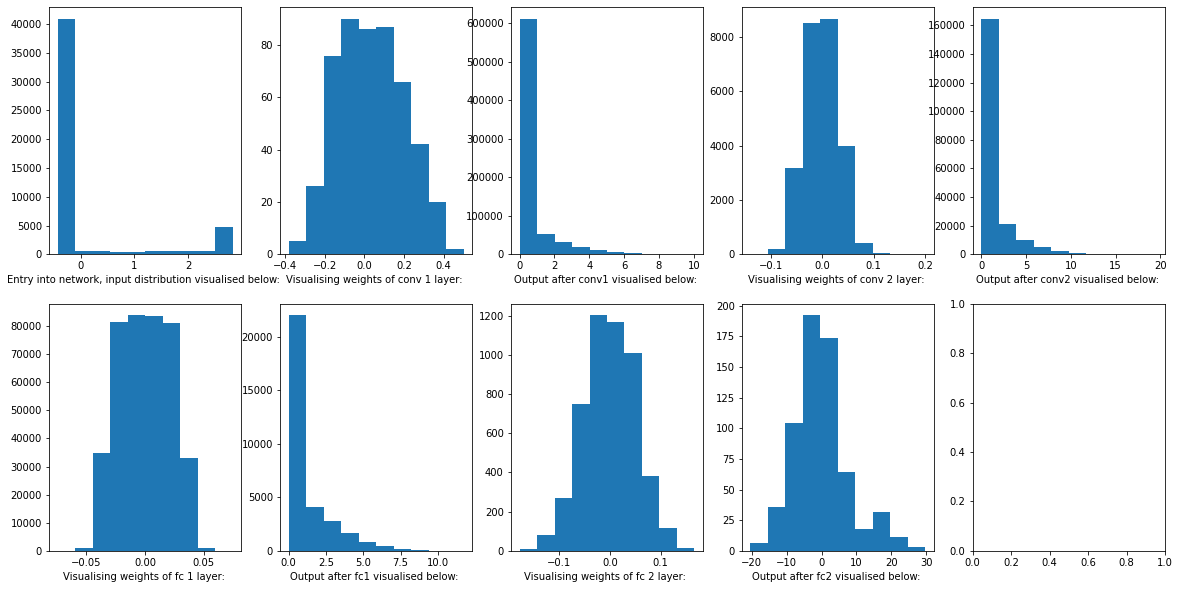

In [32]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, vis=True, axs=axs)
        break
plt.show()

## Visualise Quantised Model

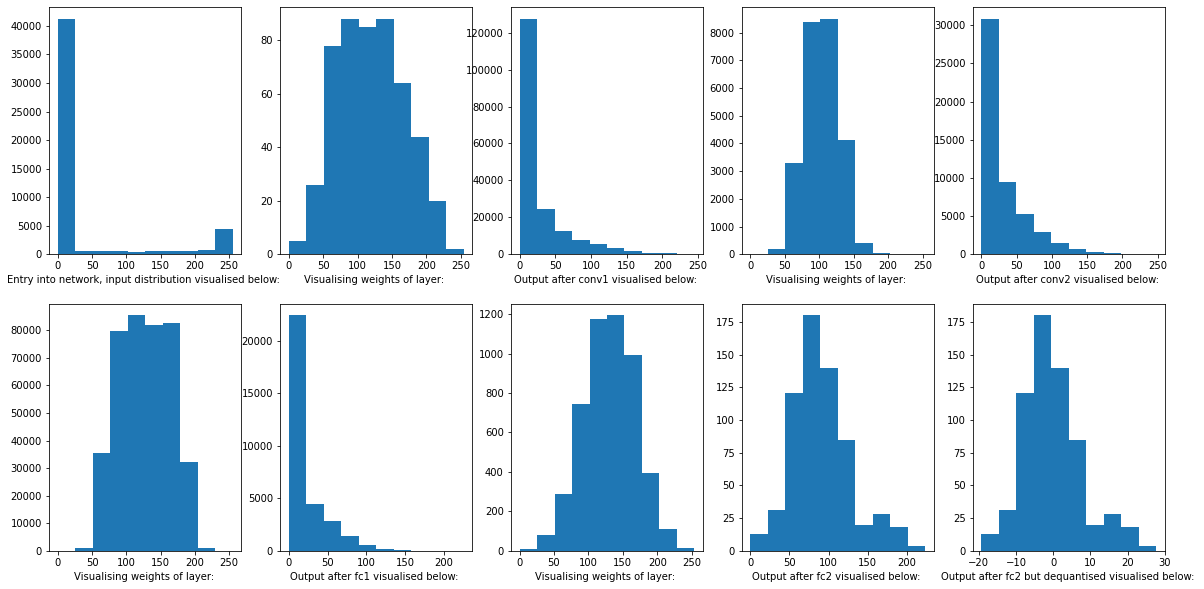

In [33]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=False, num_bits=8)
        break
plt.show()

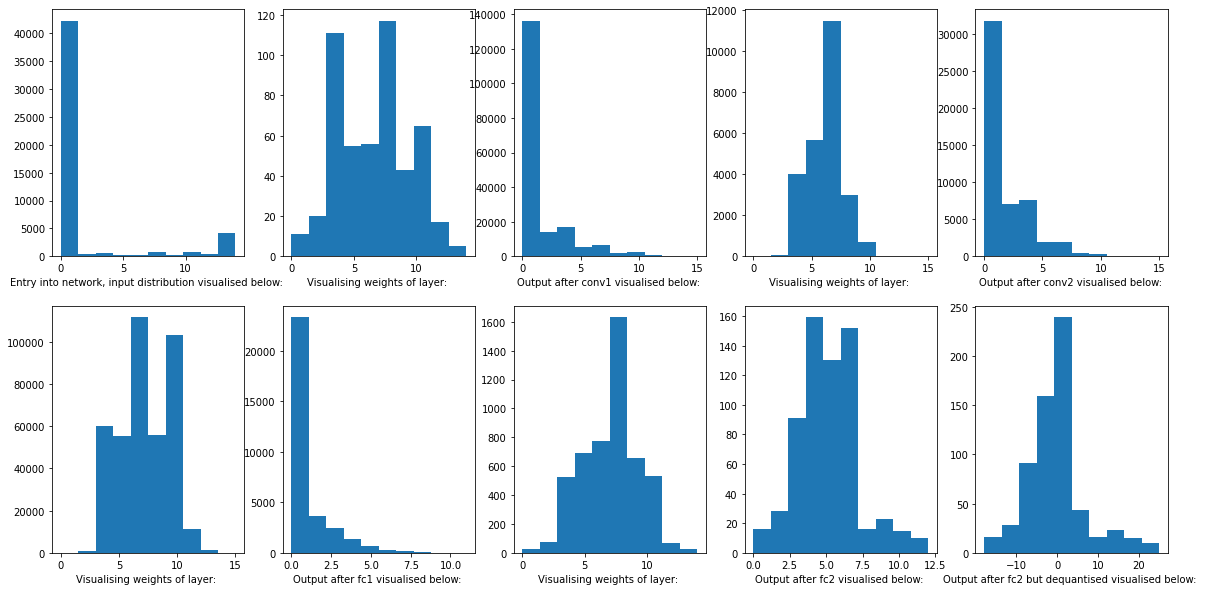

In [34]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=False, num_bits=4)
        break
plt.show()

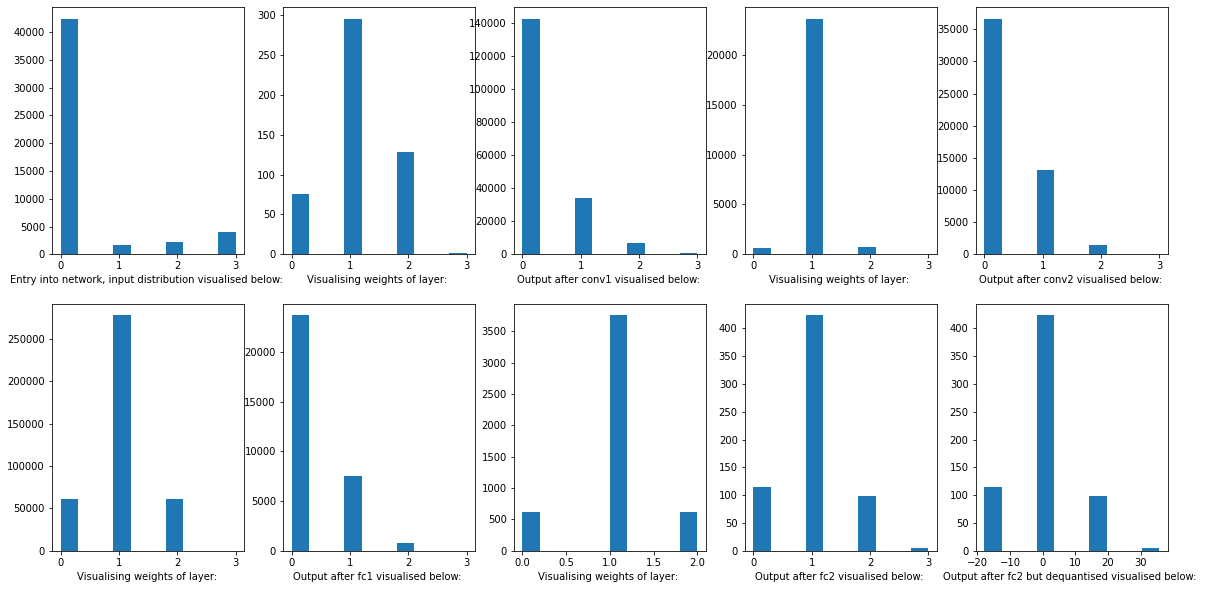

In [35]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=False, num_bits=2)
        break
plt.show()

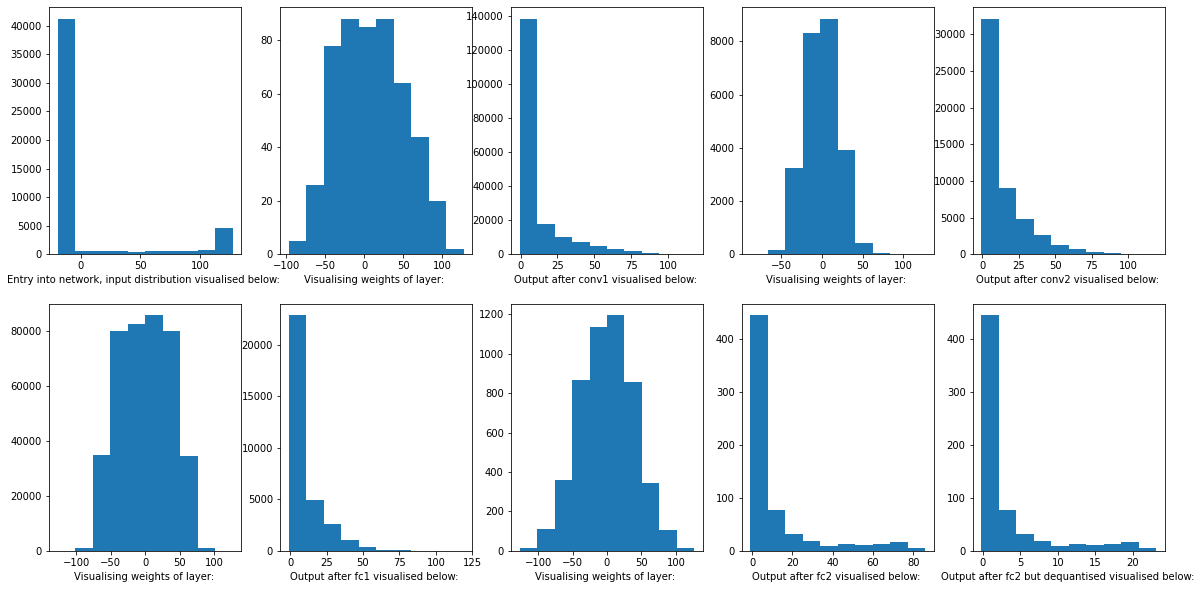

In [36]:
import matplotlib.pyplot as plt
# run through one example and plot weights and activations quantised in real time
device = 'cuda'
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = quantForward(q_model, data, stats, vis=True, axs=axs, sym=True)
        break
plt.show()

## TA DA !!

We have quantised our net to mostly 8 bit arithmetic with almost zero accuracy loss ! Pretty good day's work, I'll say :D

In [37]:
stats

{'conv1': {'max': 2.821486711502075,
  'min': -0.4242129623889923,
  'ema_min': -0.4242129623889923,
  'ema_max': 2.819079776573962},
 'conv2': {'max': 10.803265571594238,
  'min': 0.0,
  'ema_min': 0.0,
  'ema_max': 8.87393726406243},
 'fc1': {'max': 20.8812313079834,
  'min': 0.0,
  'ema_min': 0.0,
  'ema_max': 16.117833238109025},
 'fc2': {'max': 16.6160888671875,
  'min': 0.0,
  'ema_min': 0.0,
  'ema_max': 8.84634786268192},
 'out': {'max': 34.17060852050781,
  'min': -19.3685302734375,
  'ema_min': -10.063359297819348,
  'ema_max': 17.0286625233738}}

# Quantisation Aware Training

In [143]:
import torch

class FakeQuantOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_bits=8, min_val=None, max_val=None):
        x = quantize_tensor(x,num_bits=num_bits, min_val=min_val, max_val=max_val)
        x = dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # straight through estimator
        return grad_output, None, None, None

In [144]:
x = torch.tensor([1,2,3,6]).float()
print(FakeQuantOp.apply(x))

tensor([1., 2., 3., 5.])


## Quantization Aware Training Forward Pass

In [145]:
def quantAwareTrainingForward(model, x, stats, vis=False, axs=None, sym=False, num_bits=8, act_quant=False):
  
    with torch.no_grad():
        stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv1')

    if act_quant:
        x = FakeQuantOp.apply(x, num_bits, stats['conv1']['ema_min'], stats['conv1']['ema_max'])
        
    conv1weight = model.conv1.weight.data
    model.conv1.weight.data = FakeQuantOp.apply(model.conv1.weight.data, num_bits)
    x = F.relu(model.conv1(x))

    x = F.max_pool2d(x, 2, 2)
    
    with torch.no_grad():
        stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'conv2')
    
    if act_quant:
        x = FakeQuantOp.apply(x, num_bits, stats['conv2']['ema_min'], stats['conv2']['ema_max'])

    conv2weight = model.conv2.weight.data
    model.conv2.weight.data = FakeQuantOp.apply(model.conv2.weight.data, num_bits)
    x = F.relu(model.conv2(x))

    x = F.max_pool2d(x, 2, 2)
    
    with torch.no_grad():
        stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc1')

    if act_quant:
        x = FakeQuantOp.apply(x, num_bits, stats['fc1']['ema_min'], stats['fc1']['ema_max'])

    x = x.view(-1, 4*4*50)
    fc1weight = model.fc1.weight.data
    model.fc1.weight.data = FakeQuantOp.apply(model.fc1.weight.data, num_bits)
    x = F.relu(model.fc1(x))
    
    if act_quant:
        x = FakeQuantOp.apply(x, num_bits, stats['fc2']['ema_min'], stats['fc2']['ema_max'])
    
    with torch.no_grad():
        stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'fc2')
    
    fc2weight = model.fc2.weight.data
    model.fc2.weight.data = FakeQuantOp.apply(model.fc2.weight.data, num_bits)
    x = model.fc2(x)
    
    if act_quant:
        x = FakeQuantOp.apply(x, num_bits, stats['out']['ema_min'], stats['out']['ema_max'])
    
    with torch.no_grad():
        stats = updateStats(x.clone().view(x.shape[0], -1), stats, 'out')
  
    return F.log_softmax(x, dim=1), conv1weight, conv2weight, fc1weight, fc2weight,stats

# Train using Quantization Aware Training

In [153]:
def trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant=False, num_bits=8):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, conv1weight, conv2weight, fc1weight,fc2weight, stats = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)

        model.conv1.weight.data = conv1weight
        model.conv2.weight.data = conv2weight
        model.fc1.weight.data = fc1weight
        model.fc2.weight.data = fc2weight

        loss = F.nll_loss(output, target)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
        optimizer.step()

        if batch_idx % args["log_interval"] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return stats

In [154]:
def testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=8):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, conv1weight, conv2weight, fc1weight, fc2weight,_ = quantAwareTrainingForward(model, data, stats, num_bits=num_bits, act_quant=act_quant)
            
            model.conv1.weight.data = conv1weight
            model.conv2.weight.data = conv2weight
            model.fc1.weight.data = fc1weight
            model.fc2.weight.data = fc2weight

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [159]:
def mainQuantAware(mnist=True):
 
    batch_size = 64
    test_batch_size = 64
    epochs = 5
    lr = 0.01
    momentum = 0.5
    seed = 1
    log_interval = 100
    save_model = False
    no_cuda = False
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    if mnist:
        train_loader = torch.utils.data.DataLoader(
          datasets.MNIST('../tensorflow_datasets', train=True, download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
            batch_size=batch_size, shuffle=True, **kwargs)
      
        test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../tensorflow_datasets', train=False, transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])),
            batch_size=test_batch_size, shuffle=True, **kwargs)
    else:
        transform = transforms.Compose(
          [transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        trainset = datasets.CIFAR10(root='./dataCifar', train=True,
                                              download=True, transform=transform)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)
            
        testset = datasets.CIFAR10(root='./dataCifar', train=False,
                                            download=True, transform=transform)
        test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                              shuffle=False, num_workers=2)
          
  
    model = Net(mnist=mnist).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    args = {}
    args["log_interval"] = log_interval
    num_bits=2 #!
    stats = {}
    for epoch in range(1, epochs + 1):
        if epoch > 5:
            act_quant = True 
        else:
            act_quant = False

        stats = trainQuantAware(args, model, device, train_loader, optimizer, epoch, stats, act_quant, num_bits=num_bits)
        testQuantAware(args, model, device, test_loader, stats, act_quant, num_bits=num_bits)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

    return model, stats

model, old_stats = mainQuantAware()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297836
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.563341
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.334768
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.331740
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.181849
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.154233
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.274554
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.090886
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.134966
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.046801

Test set: Average loss: 0.0999, Accuracy: 9692/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.176035
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.061343
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.063193
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.080138
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.115830
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.115189
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.094504
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.086161
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.056349
T

In [160]:
model.conv2.weight

Parameter containing:
tensor([[[[-4.6794e-02, -3.2186e-02,  2.4758e-02, -9.8999e-04,  4.6134e-03],
          [-4.0808e-02,  2.1534e-02,  1.9992e-03, -5.7073e-03, -1.5275e-02],
          [ 8.8978e-03,  1.5694e-02,  1.6589e-02,  1.2907e-02, -7.2495e-03],
          [-1.8258e-02,  4.8356e-02,  1.0682e-02, -2.0542e-02,  5.3360e-02],
          [ 5.6165e-02, -1.1504e-02,  2.1553e-03,  1.8783e-02, -2.0392e-03]],

         [[ 1.2932e-02, -3.4263e-02,  2.6123e-02, -3.3554e-02,  3.2166e-02],
          [ 2.1147e-03, -1.7226e-02,  1.9963e-02, -5.7654e-02, -3.0871e-02],
          [ 1.1089e-02,  3.0216e-02, -5.2659e-02, -5.9768e-02, -2.2232e-02],
          [-2.7123e-02, -4.7982e-02, -5.9640e-02, -4.1710e-02,  4.9781e-02],
          [-2.6204e-02, -7.7020e-02, -6.7504e-02,  7.7868e-03, -2.7597e-04]],

         [[ 2.7674e-02, -1.4351e-02, -4.7653e-02, -3.5681e-02, -2.1092e-02],
          [-6.9596e-03, -7.7883e-03, -2.5584e-02,  9.2545e-04, -5.8119e-02],
          [ 3.0576e-02,  3.2176e-03, -3.0371e-02, 

## Test Quant Aware 

In [161]:
print(old_stats)

{'conv1': {'max': 2.821486711502075, 'min': -0.4242129623889923, 'total': 5475, 'ema_min': -0.4242129623889923, 'ema_max': 2.8214872927038193}, 'conv2': {'max': 10.215150833129883, 'min': 0.0, 'total': 5475, 'ema_min': 0.0, 'ema_max': 7.78837279581953}, 'fc1': {'max': 15.80428409576416, 'min': 0.0, 'total': 5475, 'ema_min': 0.0, 'ema_max': 10.411202696472772}, 'fc2': {'max': 14.750638961791992, 'min': 0.0, 'total': 5475, 'ema_min': 0.0, 'ema_max': 7.392136811916351}, 'out': {'max': 24.500396728515625, 'min': -0.19464705884456635, 'total': 5475, 'ema_min': -7.922376456285525, 'ema_max': 12.749624241451551}}


In [182]:
import copy
q_model = copy.deepcopy(model)

In [183]:
testQuant(q_model, test_loader, quant=True, stats=old_stats, sym=False, num_bits=2)


Test set: Average loss: 0.1997, Accuracy: 9102/10000 (91%)

